In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.enable_eager_execution()

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import src.gan as gan

# want to visualise the prior learned by a gan/rim/vae/...

In [46]:
# generate a simple manifold of data
N = 1000
t = np.linspace(-10, 10, N)
t = tf.constant(t, dtype=tf.float32)

def g(x):
    return tf.nn.relu(x)

data = tf.stack([t, g(t)], axis=1) # truth


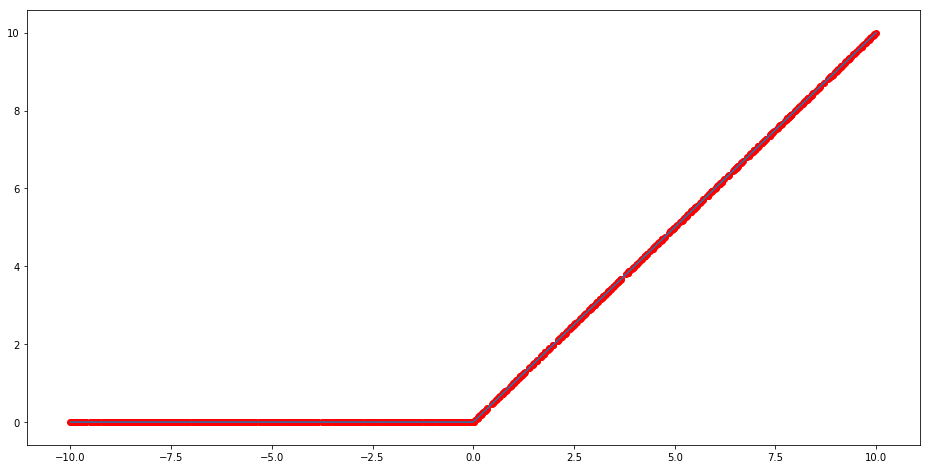

In [47]:
plt.figure(figsize=(16, 8))
plt.plot(data[:, 0], data[:, 1])

def get_batch(batch_size):
    return tf.gather(data, np.random.randint(0, N, batch_size))

batch = get_batch(1000)
plt.scatter(batch[:, 0], batch[:, 1], c='r')

In [63]:
batch_size = 100

def calc_grads(switch):
    with tf.GradientTape() as tape:
        x = get_batch(batch_size)
        z = tf.random_normal([batch_size, 1])

        fake = generator(z)
        p_real = discriminator(x)
        p_fake = discriminator(fake)

        discrim_loss = tf.losses.sigmoid_cross_entropy(
            logits=p_real,
            multi_class_labels=tf.ones_like(p_real))
        discrim_loss += tf.losses.sigmoid_cross_entropy(
            logits=p_fake,
            multi_class_labels=tf.zeros_like(p_fake))

        # generator is trying to fool the discriminator
        gen_loss = tf.losses.sigmoid_cross_entropy(
            logits=p_fake,
            multi_class_labels=tf.ones_like(p_fake))
        
    if switch:
        return list(zip(tape.gradient(discrim_loss, discriminator.variables), discriminator.variables))
    else:
        return list(zip(tape.gradient(gen_loss, generator.variables), generator.variables))           

In [66]:
width = 32
discriminator = tf.keras.Sequential([tf.keras.layers.Dense(width, activation=tf.nn.selu), 
                                     tf.keras.layers.Dense(width, activation=tf.nn.selu),
                                     tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
generator =  tf.keras.Sequential([tf.keras.layers.Dense(width, activation=tf.nn.selu), 
                                  tf.keras.layers.Dense(width, activation=tf.nn.selu),
                                  tf.keras.layers.Dense(2)])

In [67]:
n = 20
x_ = np.linspace(-10, 10, n)
y_ = np.linspace(-10, 10, n)
X, Y = np.meshgrid(x_, y_)
Z = tf.constant(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=tf.float32)

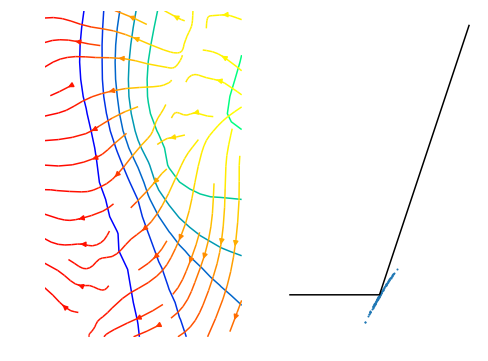

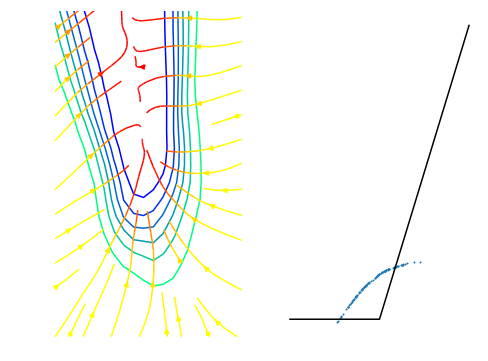

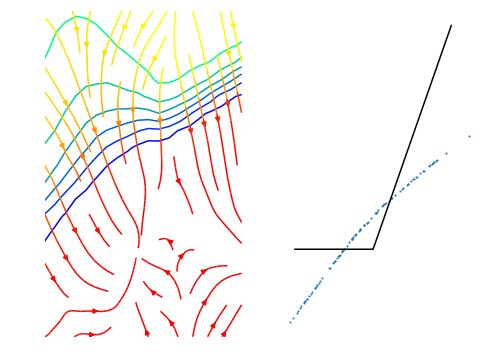

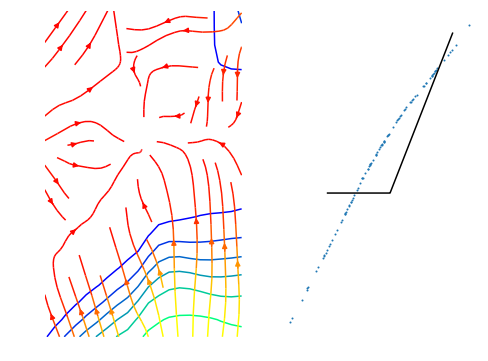

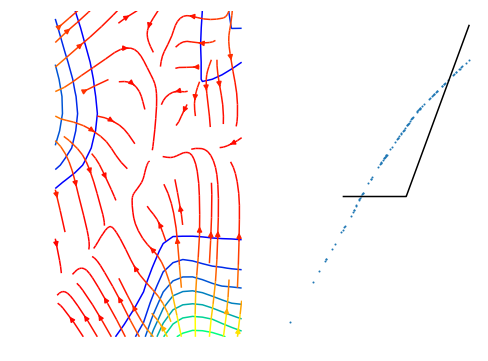

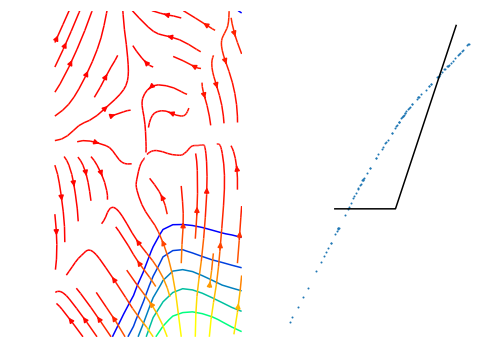

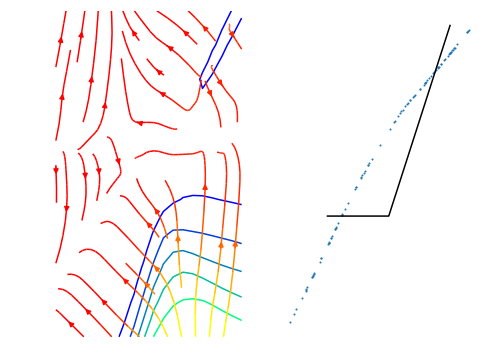

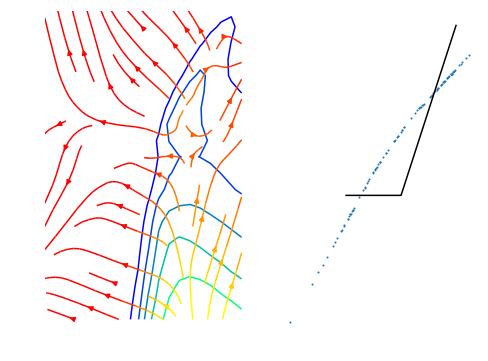

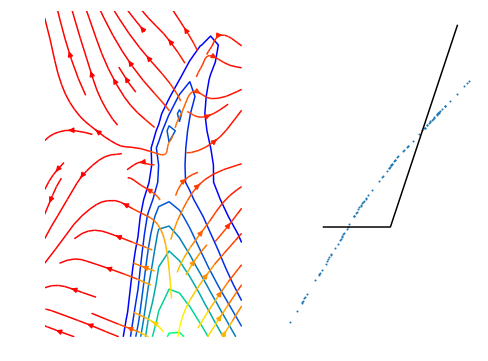

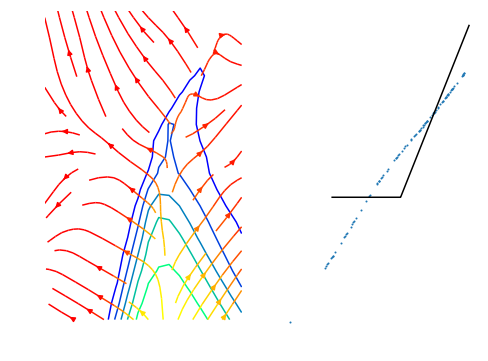

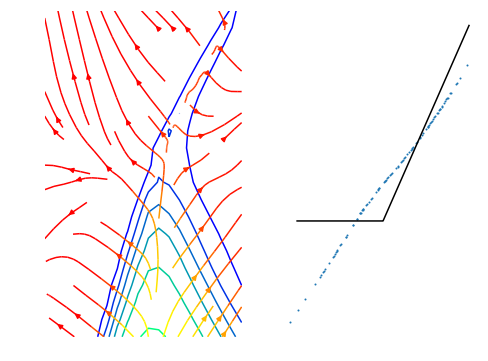

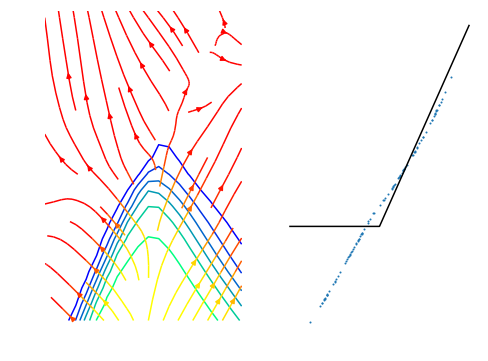

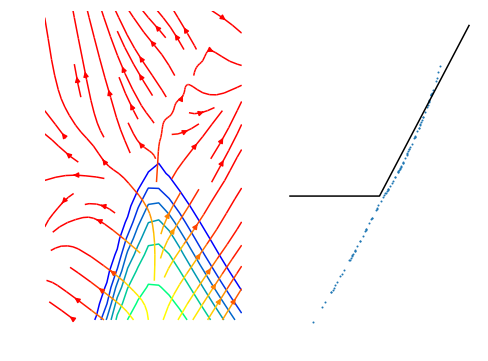

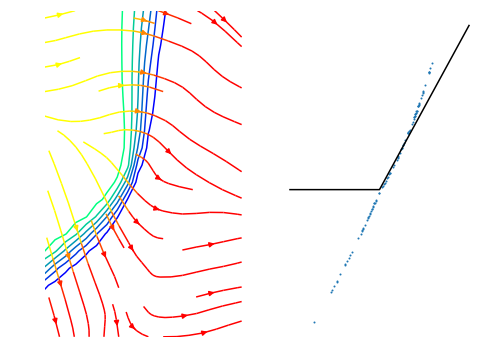

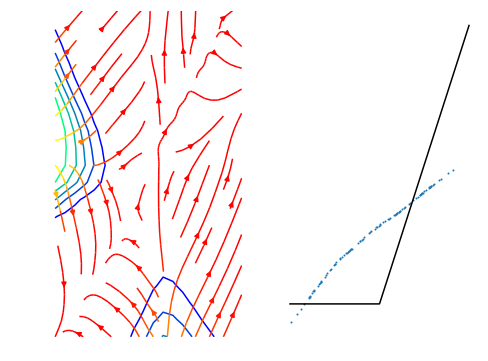

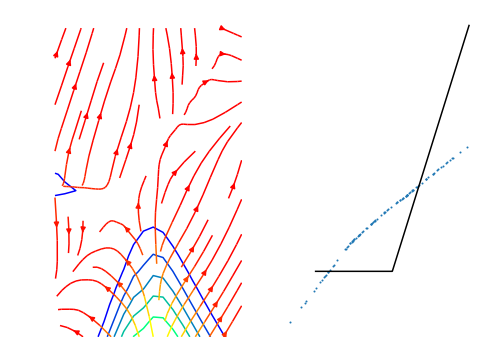

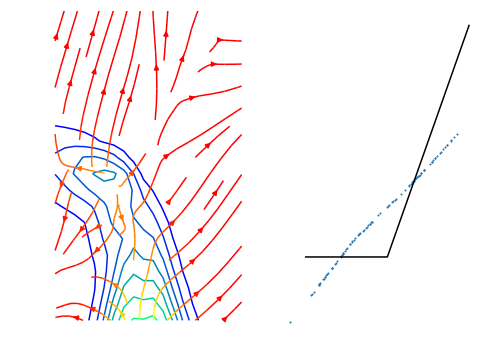

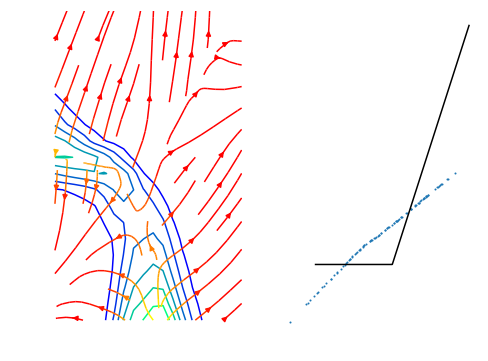

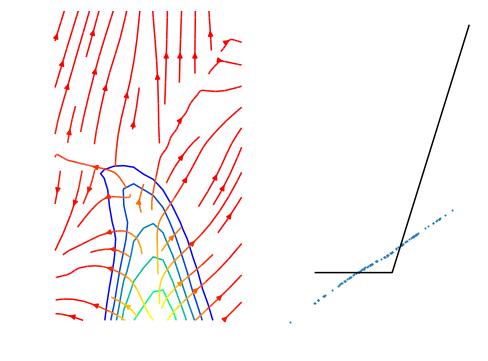

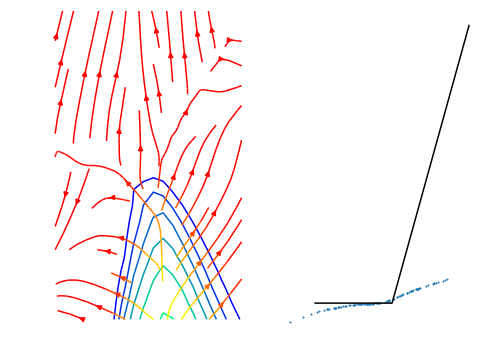

In [68]:
opt = tf.train.GradientDescentOptimizer(0.1)
count = 0
for i in range(1000):
    opt.apply_gradients(calc_grads(True))
    opt.apply_gradients(calc_grads(False))
    
    if i % 50 == 0:
        plt.figure(figsize=(12,6))

        with tf.GradientTape() as tape:
            tape.watch(Z)
            p = discriminator(Z)
        dp = tape.gradient(p, Z)
        
        plt.subplot(1,3,1)
        plt.axis('off')
        plt.contour(X, Y, np.reshape(p, [n, n]), cmap=plt.cm.winter)
        plt.streamplot(X, Y, -np.reshape(dp[:, 0], [n, n]), 
                       -np.reshape(dp[:, 1], [n, n]), 
                       density=0.5, cmap=plt.cm.autumn,
                       color= np.reshape(p, [n, n]))
        
        plt.subplot(1,3,2)
        plt.axis('off')
#         z = tf.constant(np.linspace(-3, 3, 100), dtype=tf.float32, shape=[100, 1])
        z = tf.random_normal([100, 1])
        fake = generator(z)
        plt.scatter(fake[:, 0], fake[:, 1], s=1)

        plt.plot(data[:, 0], data[:, 1], c='k')
        
        
#         plt.subplot(3,1,3)
        # generators density fn!?

In [52]:
# irrelevant for now...

class Forward():
    """
    The forward process
    """
    def __init__(self):
        Q, R = np.linalg.qr(np.random.standard_normal((2,2)))
        self.A = tf.constant(Q, dtype=tf.float32)
        self.stddev = 1.0
    
    def __call__(self, x):
        y = tf.transpose(tf.matmul(self.A, x, transpose_b=True))
        y = y[:, 0:1]  # subsample.
        return y + tf.random_normal(y.shape, stddev=self.stddev)
    
f = Forward()
y = f(data)  # observations

In [ ]:
# plt.subplot(1,2,2)
# o = y.numpy()
# idx = np.random.choice(range(len(o)), len(o), replace=False)
# plt.scatter(range(len(o)), o[idx], c=plt.cm.autumn(idx))